In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from os import walk
import re
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, find_peaks_cwt, detrend
from scipy import signal

import matplotlib.gridspec as gridspec
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

from Methods.Methods import * # collection of processing methods in _Methods directory

{'20-1': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-1.4.CSV',
 '20-2': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-2.4.CSV',
 '20-3': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-3.4.CSV',
 '20-4': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-4.3.CSV',
 '20-6': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-6.4.CSV',
 '20RGD-1': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20RGD-1.4.CSV',
 '20RGD-3': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20RGD-3.4.CSV',
 '20RGD-4': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20RGD-4.1.CSV',
 '20RGD-5': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20RGD-5.4.CSV',
 '20RGD-6': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analys

In [2]:
def calculate_regression_line_stress_strain(Strain,Stress):
        #x = Strain, y = Stress_N_msquared
        #y = self.data['Stress_N_msquared'].values
        #x = self.data['Strain'].values

        #solve LLS Optimization problem min ||y - Phi*Theta||_2^2, Phi being [[1, x_0]^T,...,[1,x_N]^T]T
        Phi = np.array([np.ones(len(Strain)),Strain.values]).T
        Theta = np.linalg.inv(Phi.T @ Phi)@Phi.T @ Stress
        return Theta

In [41]:
#obtain all sample names and respective paths in given directory
data_dir = r'D:\02_RESEARCH\08_Dynamic Mechanical Analysis\Messungen\Neuer Ordner\CSV'
dic = getFileContent(data_dir)

d = {}
for key in dic.keys(): 
    sample = key.split('.')[0]
    value = dic[key]
    d[sample] = value
    #dic = [s.split('.')[0] for s in dic.keys()]
d

{'20-1': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-1.4.CSV',
 '20-2': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-2.4.CSV',
 '20-3': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-3.4.CSV',
 '20-4': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-4.3.CSV',
 '20-6': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20-6.4.CSV',
 '20RGD-1': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20RGD-1.4.CSV',
 '20RGD-3': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20RGD-3.4.CSV',
 '20RGD-4': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20RGD-4.1.CSV',
 '20RGD-5': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\20RGD-5.4.CSV',
 '20RGD-6': 'D:\\02_RESEARCH\\08_Dynamic Mechanical Analys

In [42]:
#load geometry data from excel file
geometries = pd.read_excel(r'D:\02_RESEARCH\08_Dynamic Mechanical Analysis\Messungen\Neuer Ordner\DMA_BoseRolauffs_2020-12-22.xlsx',sheet_name='Geometrie')

#only keep data for cyclical experiments
geometries = geometries[geometries.zyklisch == 'x']
geometries.Probe = geometries.Probe.astype('Int32').astype('str')  
geometries['sample_name'] = geometries.Protein.str.replace('-','').str.lstrip('V')+'-'+geometries.Probe
geometries['Geldicke'] = 0.580

#only keep necessary columns
df_geometries = geometries[['sample_name','Gelbreite','Geldicke','Spaltbreite']]
df_geometries

,sample_name,Gelbreite,Geldicke,Spaltbreite
0,20-1,3.0,0.58,3.0
2,20-2,2.5,0.58,3.0
4,20-1,3.0,0.58,3.0
6,20-2,2.8,0.58,2.8
8,20-3,3.0,0.58,2.0
10,20-4,3.0,0.58,2.5
12,20-5,3.0,0.58,2.0
14,20-6,3.0,0.58,1.5
16,20RGD-1,3.0,0.58,2.0
18,20RGD-2,3.0,0.58,1.0


<IPython.core.display.Javascript object>


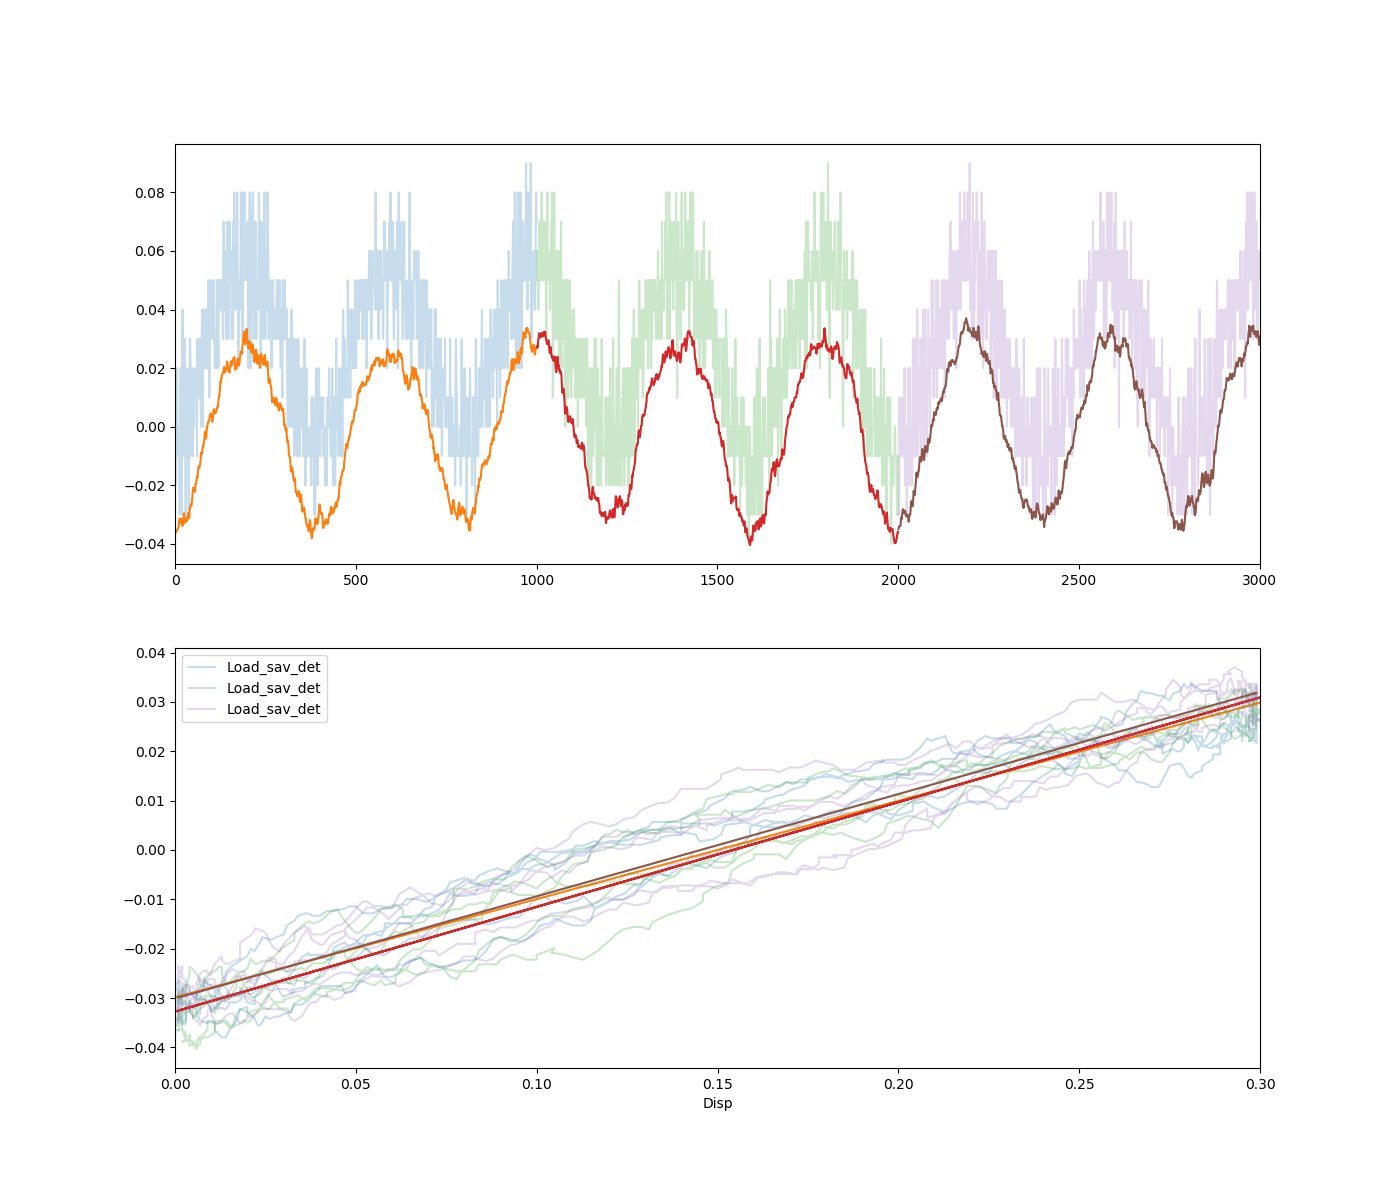

E: max: 0.212, min: 0.199, mean: 0.206, std: 0.005415


c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
from matplotlib import interactive
%matplotlib notebook 

data = {}
names = ['Points','Elapsed_Time','Scan_Time','Disp','Load','E12_%','E22_%','Axial_cmd_V','Axial_err_%','Unnamed']
path = r'D:\02_RESEARCH\08_Dynamic Mechanical Analysis\Messungen\Neuer Ordner\CSV\20-6.1.csv'
header = 100

print(sample_name)
#load data into dataframe
df = pd.read_csv(path,header=1000,names=names,index_col=False)
df['source'] = 'source'

#drop duplicate row
df = df.drop_duplicates(subset='Elapsed_Time',keep='first')

#create walking continuous index
df.Points = [i for i in range(1, len(df) + 1)]

#keep 10000 points
df = df[:10000]

#smoothen data 
df['Load_sav'] = savgol_filter(df.Load,21,1)

#detrend data
df['Load_sav_det'] = detrend(df.Load_sav)

split_up_data = []
thetas = []
f = plt.figure(figsize=(14,12))
ax = f.add_subplot(2,1,1)
ax1 = f.add_subplot(2,1,2)

for i in range(3):
    tmp = df[i*1000:(i+1)*1000]
    tmp.Load.plot(ax=ax,alpha=0.25)
    tmp.Load_sav_det.plot(ax=ax)
    
    #calculate youngs modulus
    theta_temp = calculate_regression_line_stress_strain(Strain=tmp.Disp,Stress=tmp.Load_sav_det)
        
    #plot ellipses
    tmp.plot(x='Disp',y='Load_sav_det',ax=ax1,alpha=0.25)
    
    #plot youngs modulus
    x = tmp.Disp.values
    Phi = np.array([np.ones(len(x)),x]).T
    y = Phi@theta_temp
    plt.plot(x,y)
    
    tmp['theta'] = theta_temp[1]
    thetas.append(theta_temp[1])
    split_up_data.append(tmp)

df_thetas = pd.DataFrame(thetas)
print('E: max: {:.3f}, min: {:.3f}, mean: {:.3f}, std: {:.6f}'.format(np.max(thetas),
                                                                      np.min(thetas),
                                                                      np.mean(thetas),
                                                                      np.std(thetas)))

In [2]:
print('Following files have been found:')
for i in dic.keys():
    print(dic[i])

Following files have been found:
Messungen\20190813\15% v20_10%.CSV
Messungen\20190813\15% v20_20%.CSV
Messungen\20190813\15% v40_20%.CSV
Messungen\20190828\Messung 1_V20-10-1\20190828 v20,10-1-reissen.CSV
Messungen\20190828\Messung 1_V20-10-1\20190828 v20,10-1-reissen2.CSV
Messungen\20190828\Messung 1_V20-10-1\20190828 v20,10-1.CSV
Messungen\20190828\Messung 2_V20,10-2\20190828 v20,10-2-reissen.CSV
Messungen\20190828\Messung 2_V20,10-2\20190828 v20,10-2.CSV
Messungen\20190828\Messung 3_V20,20-1\20190828 v20,20-1-reissen.CSV
Messungen\20190828\Messung 3_V20,20-1\20190828 v20,20-1.CSV
Messungen\20190828\Messung 3_V20,20-1\20190828 v20,20-1wdh.CSV
Messungen\20190828\Messung 4_V40-3\20190828 v40-3-reissen.CSV
Messungen\20190828\Messung 4_V40-3\20190828 v40-3-reissen2.CSV
Messungen\20190828\Messung 4_V40-3\20190828 v40-3.CSV
Messungen\20190828\Messung 5_V20,20-3\20190828 v20,20-3,reissen.CSV
Messungen\20190828\Messung 5_V20,20-3\20190828 v20,20-3.CSV
Messungen\20190828\Messung 6_V40-2\2019

In [3]:
# split data for cyclical analysis and ripping force analysis
# read all csv data into one list 
datasets = {}#filename = []

#renaming those absolutely horribly chosen column names
names = ['Points','Elapsed_Time_Sec','Scan_Time_Sec','Disp_mm','Load_2_N','E12_%','E22_%','Axial_cmd_V','Axial_err_%','Unnamed']

for key in dic.keys():
    #print(key)
    len_tmp = pd.read_csv(dic[key], index_col = False, names=names).shape[0]
    if len_tmp >2:
        datasets[key] = pd.read_csv(dic[key],header = 2, index_col = False, names=names)
        datasets[key]['Short'] = 0
        #if re.search(r"reis", key) == 1:
        #    print('RISS')
        #print(datasets[key].head())
    else:
        #print('tiny data set')
        datasets[key] = pd.read_csv(dic[key], index_col = False, names=names)
        datasets[key]['Short'] = 1
        #print('short')
    len_tmp = 0
    

ncyc = 4000
n_init_cyc = {'20_10_1': ncyc,
			  '20_10_2': ncyc,
			  '20_10_3': ncyc,
			  '20_20_1': ncyc,
			  '20_20_2': ncyc,
			  '20_20_3': ncyc,
			  '40_1': ncyc,
			  '40_2': ncyc,
			  '40_3': ncyc}

 
n_len_cyc  = 8000

data_rip = {#'20_10_1_r': datasets['20190828 v20,10-1-reissen.CSV'],
            #'20_10_2_r': datasets['20190828 v20,10-2-reissen.CSV'],
            '20_10_3_r': datasets['20190828 v20-3-reissen.CSV'],
            #'20_20_1_r': datasets['20190828 v20,20-1-reissen.CSV'],
            '20_20_2_r': datasets['20190828 v20,20-2,reissen.CSV'],
            #'20_20_3_r': datasets['20190828 v20,20-3,reissen.CSV'],
            #'40_1_r': datasets['20190828 v40-1-reissen.CSV'],
            '40_2_r': datasets['20190828 v40-2-reissen.CSV'],
            #'40_3_r': datasets['20190828 v40-3-reissen.CSV'],
            #'40_3_r2': datasets['20190828 v40-3-reissen2.CSV']
            }

data_cyc = {'20_10_1': datasets['20190828 v20,10-1.CSV'],
            '20_10_2': datasets['20190828 v20,10-2.CSV'],
            '20_10_3': datasets['20190828 v20-3.CSV'],
            '20_20_1': datasets['20190828 v20,20-1.CSV'],
            '20_20_2': datasets['20190828 v20,20-2.CSV'],
            '20_20_3': datasets['20190828 v20,20-3.CSV'],
            '40_1': datasets['20190828 v40-1.CSV'],
            '40_2': datasets['20190828 v40-2.CSV'],
            '40_3': datasets['20190828 v40-3.CSV'],
            }

#dimensions in the form height x width x length
dimensions_mm = {'20_10_1':[0.580,5,2],
                '20_10_2':[0.580,5,2],
                '20_10_3':[0.580,5,1.5],
                '20_20_1':[0.580,4.5,1.5],
                '20_20_2':[0.580,5,1.5],
                '20_20_3':[0.580,5,2],
                '40_1':[0.580,4,1],
                '40_2':[0.580,5,1],
                '40_3':[0.580,3.5,1],
                '20_10_1_r':[0.580,5,2],
                '20_10_2_r':[0.580,5,2],
                '20_10_3_r':[0.580,5,1.5],
                '20_20_1_r':[0.580,4.5,1.5],
                '20_20_2_r':[0.580,5,1.5],
                '20_20_3_r':[0.580,5,2],
                '40_1_r':[0.580,4,1],
                '40_2_r':[0.580,5,1],
                '40_3_r':[0.580,3.5,1],
                '40_3_r2':[0.580,3.5,1]
                }

idx_max = {     #'20_10_1_r':0,
                #'20_10_2_r':[1950,1970],
                '20_10_3_r':[1950,2000],
                #'20_20_1_r':0,
                '20_20_2_r':[1485,1600],
                #'20_20_3_r':0,
                #'40_1_r':0,
                '40_2_r':[1385,1500],
                #'40_3_r':[1400,1415],
                #'40_3_r2':[1180,1190]
                }

titles = {'20_10_1': 'ULD-V20-ULD, 10 % \n Sample 1',
            '20_10_2': 'Sample 2',
            '20_10_3': 'Sample 3',
            '20_20_1': 'ULD-V20-ULD, 20 % \n Sample 1',
            '20_20_2': 'Sample 2',
            '20_20_3': 'Sample 3',
            '40_1': 'ULD-V40-ULD, 20 % \n Sample 1',
            '40_2': 'Sample 2',
            '40_3': 'Sample 3',
            }


# throw out all data before n_init
for key in data_cyc.keys():
    data_cyc[key] = data_cyc[key][data_cyc[key].Points != 1600]
    data_cyc[key] = data_cyc[key][n_init_cyc[key]:n_init_cyc[key]+n_len_cyc].reset_index()

data_rip['20_10_3_r'] = data_rip['20_10_3_r'].iloc[:-20] 


print(30*'='+'MAXIMUM STRESS'+30*'=')
for key in data_rip.keys():
    print('{} has shape '.format(key), data_rip[key].shape)

print(70*'=')
print(' ')

print(30*'='+'CYCLICAL STRESS'+30*'=')
for key in data_cyc.keys():
    print('{} has shape '.format(key), data_cyc[key].shape)
  #  print(data_cyc[key][795:815])
print(70*'=')
print(' ')


==============================MAXIMUM STRESS==============================
20_10_3_r has shape  (2061, 11)
20_20_2_r has shape  (1650, 11)
40_2_r has shape  (1571, 11)
 
==============================CYCLICAL STRESS==============================
20_10_1 has shape  (8000, 12)
20_10_2 has shape  (8000, 12)
20_10_3 has shape  (8000, 12)
20_20_1 has shape  (8000, 12)
20_20_2 has shape  (8000, 12)
20_20_3 has shape  (8000, 12)
40_1 has shape  (8000, 12)
40_2 has shape  (8000, 12)
40_3 has shape  (8000, 12)
 


In [4]:
for key in data_rip.keys(): 
    data_rip[key]['Fs'] = savgol_filter(data_rip[key].Load_2_N,15,1)

    #rename and drop columns
    data_rip[key] = data_rip[key][['Disp_mm','Load_2_N','Fs']]
    data_rip[key].columns = ['D','F','Fs']
    #f = plt.figure(figsize = (14,12))
    #ax = f.add_subplot()
    #data_rip[key].plot(y=['Fs'], ax = ax)
    #plt.plot(data_rip[key].D, s)
    #####spit out plot
    #data_rip[key].plot(y=['D','F','Fs'],figsize = (20,10), title = key)

c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
#dicts to store the standard deviations for rising and falling flanks for the different cyclical datasets    
stds_rising = {}
stds_falling = {}

for key in data_cyc.keys():
    
    #create a mask for the fft and apply it. after that, shift data upwards to be above zero for causality
    mask = np.ones((data_cyc[key].shape[0]))
    
    '''
    t = np.abs(np.real(np.fft.fft(data_cyc[key].Load_2_N)))[:1000]
    plt.figure(figsize=(15,10))
    plt.plot(t)
    plt.show()
    print(np.argsort(t))
    '''
    mask[0:200] = 0
    mask[-199:] = 0
    mask[201:-200] = 0

    data_cyc[key]['Ff'] = filter_fourier(data_cyc[key].Load_2_N, mask)
    data_cyc[key]['Ff'] = data_cyc[key]['Ff'] - np.min(data_cyc[key]['Ff'])
    
    #create rising and falling flags for all cyclical datasets
    r_tmp = []
    for i in range(data_cyc[key].shape[0]-1):
        if data_cyc[key].Disp_mm.iloc[i] <= data_cyc[key].Disp_mm.iloc[i+1]:
            r_tmp.append(1)
        elif data_cyc[key].Disp_mm.iloc[i]> data_cyc[key].Disp_mm.iloc[i+1]:
            r_tmp.append(-1)
        if i == data_cyc[key].shape[0]-2:
            r_tmp.append(r_tmp[-1])
 
    data_cyc[key]['Rise'] = r_tmp
    stds_rising[key] = np.var(data_cyc[key]['Ff'][data_cyc[key].Rise == 1])**0.5
    stds_falling[key] = np.var(data_cyc[key]['Ff'][data_cyc[key].Rise == -1])**0.5
    
    n_bins = 13
    #bin the displacement data for later use
    data_cyc[key]['D_bin']  = pd.cut(data_cyc[key]['Disp_mm'],n_bins,labels=False)

    #rename and drop columns
    data_cyc[key] = data_cyc[key][['Disp_mm','Load_2_N','Ff','Rise','D_bin']]
    data_cyc[key].columns = ['D','F','Ff','R','Dbin']

In [6]:
#lets see what we can do here testwise
sigmas = []
epsilons = []
ruptures = {}
%matplotlib inline
for key in data_rip.keys():
    key = key
    d = data_rip[key].copy()
 
    id_max = idx_max[key][0]
    id_min = idx_max[key][1]

    h_gel_mm = dimensions_mm[key][0] 
    b_gel_mm = dimensions_mm[key][1]
    l_gel_mm = dimensions_mm[key][2]

    sigmas.append((d.Fs[id_max])/(b_gel_mm*h_gel_mm))
    epsilons.append(d.D[id_max]/l_gel_mm)
    data = []
    dF = d.Fs[id_max:id_min].max() - d.Fs[id_max:id_min].min()
    data = [1e6*(dF/(b_gel_mm*h_gel_mm)), (d.D[id_max]/l_gel_mm)]
    ruptures[key] = data
    
    #f = plt.figure(figsize=(20,15))
    #ax = f.add_subplot()
    d.D  = d.D / l_gel_mm
    #d.iloc[300:].plot(y=['F','Fs'],x='D', ax = ax)

In [ ]:
ruptures

In [ ]:
#saving rupture data to csv file
#dfrupt = pd.DataFrame.from_dict(ruptures,orient='index').T
#dfrupt.index = ['Stress at rupture in N/m^2','strain at rupture']
#dfrupt
#dfrupt.to_csv('rupture_data.csv')
#ylims[0]

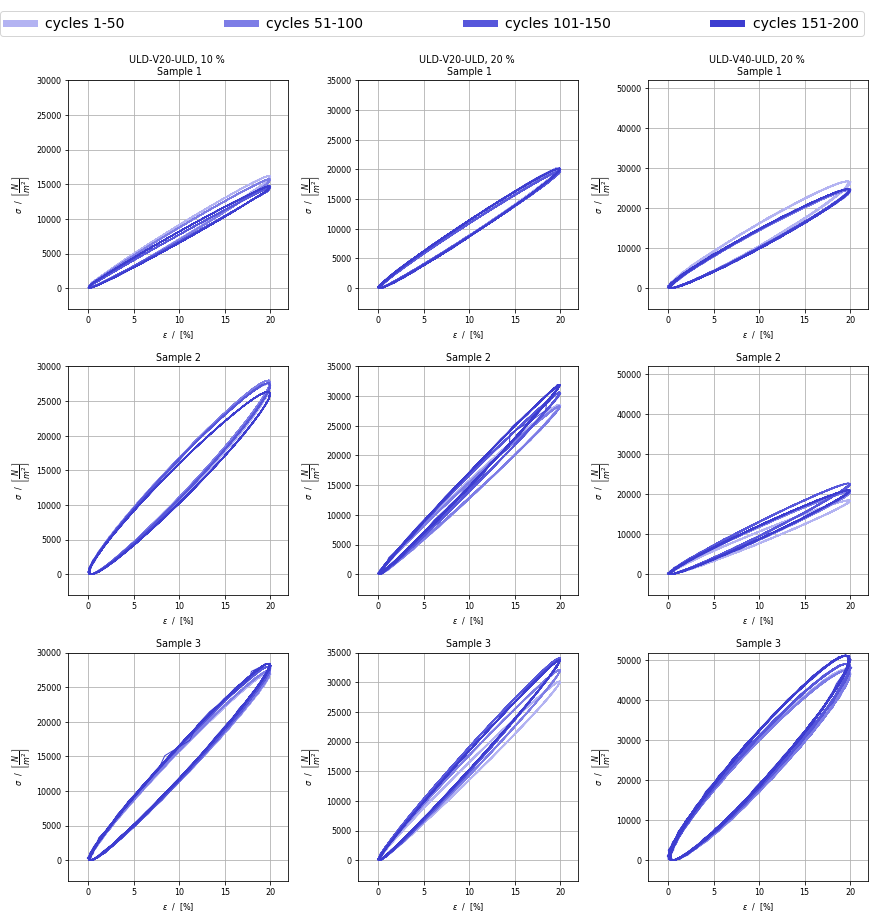

In [7]:
import copy

mpl.rcParams['font.size'] = 8
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'

sigma_string = r'$\sigma$  /  $\left[\dfrac{N}{m^2}\right]$'
eplsilon_string = r'$\varepsilon$  /  $\left[ \% \right]$'
y_modulus = {}

fig = plt.figure(constrained_layout=True, figsize=(12,12))
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
nc = 0
nr = 0


# Set scale_axes = True, if plot axes shoudl be scaled to same maximum value fgür each gel type
scale_axes = True
ylims = {'0':30000,'1':35000,'2':52000}
xlims = 22



#iterate through columns
for key in data_cyc.keys():
    if nr == 3:
        nc +=1
        nr = 0
 
    ax = fig.add_subplot(spec[nr,nc])
    d = data_cyc[key]
    
    # get geometric data of gels for sigma and epsilon
    
    h_gel_mm = dimensions_mm[key][0] 
    b_gel_mm = dimensions_mm[key][1]
    l_gel_mm = dimensions_mm[key][2]
    
    #plot 4 curves, each consisting of 2000 points, to investigate fatigue
    
    for k in range(1,5):
       
        dtot = data_cyc[key].iloc[(k-1)*2000:k*2000].copy()
        mask = np.ones((dtot.shape[0]))
        mask[0:50] = 0
        mask[-49:] = 0

        mask[51:-50] = 0

        dtot['Ff'] = filter_fourier(dtot.F, mask)
        dtot['Ff'] = dtot['Ff'] - np.min(dtot['Ff'])
        dtot['Eps'] = 100 * (dtot.D / l_gel_mm)
        dtot['Sigma'] = 1e6 * (dtot.Ff / (h_gel_mm*b_gel_mm))
        
        dtot.plot(x='Eps',y='Sigma', ax = ax, color = (.7**k, .7**k, .95**k), label = 'cycles '  + str(int((k-1)*2000/40+1))+ '-' +str(int(k*2000/40)))
                
        df = np.max(dtot['Ff']) - np.min(dtot['Ff'])
        dsigma = df/(b_gel_mm*h_gel_mm)
        
        epsilon = (np.max(dtot['D']) - np.min(dtot['D']))/l_gel_mm
        #save the youngs modulus for each cycle group
        y_modulus[key+'_'+str(k)] = 1e6*dsigma/epsilon
        
        # remove legends from all subplots
        ax.get_legend().remove()
        
   # ax.set_ylim([-0.01,0.10])
    ax.set_title(titles[key])
    ax.set_xlabel(eplsilon_string)
    ax.set_ylabel(sigma_string)
    
    if scale_axes:
        ax.set_ylim([-0.1*ylims[str(nc)],ylims[str(nc)]])
        ax.set_xlim([-0.1*xlims,xlims])
        ax.grid(True)
    nr += 1
    
#get handels and labels for the last axes to create a single legend above all subplots
handles, labels = ax.get_legend_handles_labels()
# copy the handles

handles = [copy.copy(ha) for ha in handles]

# set the linewidths to the copies
[ha.set_linewidth(7) for ha in handles]

fig.legend(handles, 
           labels, 
           ncol=4, 
           borderaxespad=0., 
           fontsize = 14,
           mode="expand",
           #loc='upper center', 
           bbox_to_anchor=(0., .95, 1., .102))


#fig.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)

#plt.tight_layout()
    
nc = 0    

fig.savefig('Figure3_DMA.svg',format='svg',bbox_inches = 'tight')
fig.savefig('Figure3_DMA.png',format='png',bbox_inches = 'tight',dpi=200)

In [ ]:
#y_modulus
dfyoung = pd.DataFrame.from_dict(y_modulus,orient='index').reset_index()
dfyoung.columns=['Gel','E']
dfyoung.Gel = dfyoung.Gel.str.slice(0,-2)
dfyoung_grouped = dfyoung.groupby('Gel').agg({'E': [np.mean,np.std]}).round(2)
dfyoung_grouped.columns = ['E_mu','E_std']
dfyoung_grouped.to_csv('y_mod_grouped.csv')

In [ ]:
f = plt.figure(figsize = (10,10))
ax = f.add_subplot(1,1,1)
data_cyc['20_10_1'][:500].plot(y='Ff', ax = ax)

In [ ]:
#sub = pd.DataFrame.from_dict(y_modulus,orient='index')
#sub
#sub.to_csv('y_mod.csv')

In [ ]:
#ruptures
#sub_rup = pd.DataFrame.from_dict(ruptures, orient='index')
#sub_rup.to_csv('rup.csv')

In [ ]:
##=========================================================##
##HERE COMES THE DMA DATA FROM THE 22.12.2020##
data_dir = 'Messungen/DMA 22.12.2020/'
files = getFileContent(data_dir)

datasets = {}

#renaming those absolutely horribly chosen column names
names = ['Points','Elapsed_Time_Sec','Scan_Time_Sec','Disp_mm','Load_2_N','E12_%','E22_%','Axial_cmd_V','Axial_err_%','Unnamed']
k=0
for i in files.keys():
    df = pd.read_csv(files[i],header = 2, index_col = False,names=names)
    if (df.shape[0]<10000) | (files[i][-5]  != '1'):
        continue
    df = df.iloc[4000:12000].Load_2_N.values
    print(i)
    
    #obtain hightes spectral energy but kill dc component at index zero
    spectrum = df.copy()
    spectrum = np.fft.fft(spectrum)#.reshape(8000,1)
    spectrum[0] = 0
    figsize = (14,12)
    plt.figure(figsize=figsize)
    plt.plot(spectrum)
    plt.title(i)
    
    print(np.argmax(spectrum[:4000]))
    f_accept = np.argmax(np.abs(np.real(spectrum[:4000])))
    bw = 0
    
    mask = np.zeros((8000))
    mask[f_accept-bw:f_accept+bw+1] = 1
    mask[-f_accept-bw:-f_accept+bw+1] = 1
    
    result = spectrum*mask
    result = np.real(np.fft.ifft(result))
    
    plt.figure(figsize=figsize)
    plt.plot(result[:1000],alpha=0.45, label=i)
    plt.plot(df[:1000],alpha=0.45)
    plt.legend()
    k+=1
    if k==20:
        break


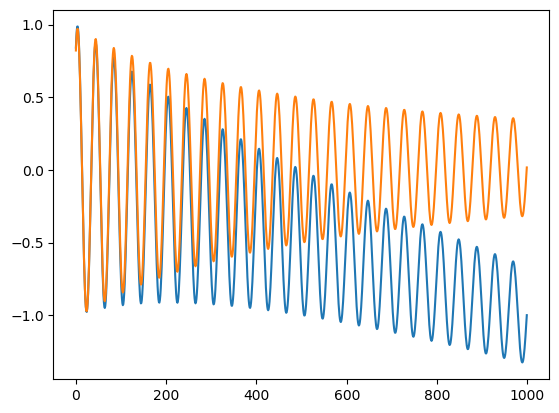

In [75]:
t = np.linspace(1,50*np.pi,1000)
scale = np.linspace(1,3,1000)
scaley = np.linspace(0,1,1000)

y = np.sin(t)
y = np.true_divide(y,scale)-scaley
plt.plot(y)

plt.plot(detrend(y))